In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d deadskull7/fer2013

 92% 89.0M/96.6M [00:01<00:00, 61.7MB/s]
100% 96.6M/96.6M [00:01<00:00, 76.9MB/s]


In [8]:
!ls

fer2013.zip  kaggle.json  sample_data


In [9]:
!unzip -l fer2013.zip

Archive:  fer2013.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
301072766  2019-10-01 04:15   fer2013.csv
---------                     -------
301072766                     1 file


In [10]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [11]:
!ls

fer2013.csv  fer2013.zip  kaggle.json  sample_data


In [12]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [13]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [14]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Imports

In [85]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

2.2.4
1.15.2


In [0]:
import numpy as np
import os
from keras import callbacks
from keras.utils.vis_utils import plot_model

import warnings 
warnings.filterwarnings('ignore')

# Layers in CapsNet

Define the key layers required to build any capsnet architecture

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (0.5 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transformation matrix/Weight matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate(tile) num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))

        # DYNAMIC ROUTING
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # update the raw weights for the next routing iteration
                # by adding the agreement to the previous raw weights
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

# Build the network

Build the required capsnet architecture using the layers defined above

In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Conventional Conv2D layer  
    conv1 = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv2 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv2')(conv1)
    conv2 = layers.BatchNormalization(momentum=0.6)(conv2)
    conv2 = layers.Dropout(0.4)(conv2) # add regularization

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Dynamic Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digit_caps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(256, activation='relu')(masked)
    x_recon = layers.Dense(512, activation='relu')(x_recon)
    x_recon = layers.Dense(2304, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[48, 48, 1], name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

# Margin Loss

Use custom margin loss as proposed in the original paper for gradient updates

In [0]:
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
    return K.mean(K.sum(L, 1))

def margin_loss_hard(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.95 - y_pred)) + 0.75 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.0625))
    return K.mean(K.sum(L, 1))

In [125]:
num_classes = 7
routings = 3

# define model
model = CapsNet(input_shape=[48, 48, 1],
                n_class=num_classes,
                num_routing=routings)
model.summary()

try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 64)   5248        input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 256)  1327360     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 8192, 8)      0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
lambda_8 (

# Load Data

In [126]:
# COMMON
import pandas as pd
data = pd.read_csv('fer2013.csv')
print(data.head())
print(data.Usage.unique())

print(data.emotion.value_counts())
print(data.Usage.value_counts())

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
['Training' 'PublicTest' 'PrivateTest']
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


In [127]:
# HETH
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [0]:
# COMMON
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [129]:
# HETH
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
x_train, y_train = CRNO(data_train, "train") #training data
x_val, y_val = CRNO(data_val, "val") #validation data
x_test, y_test = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [0]:
## ME
# from keras.utils import to_categorical

# train_set = data[(data.Usage == 'Training')]
# val_set = data[(data.Usage == 'PublicTest')]
# test_set = data[(data.Usage == 'PrivateTest')]

# # IMAGES
# x_train = np.array(list(map(str.split, train_set.pixels)), np.float32)
# x_val = np.array(list(map(str.split, val_set.pixels)), np.float32)
# x_test = np.array(list(map(str.split, test_set.pixels)), np.float32)

# x_train = x_train.reshape(x_train.shape[0], 48, 48, 1) 
# x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
# x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)

# # LABELS
# y_train = train_set.emotion 
# y_train = to_categorical(y_train, num_classes) 

# y_val = val_set.emotion 
# y_val = to_categorical(y_val, num_classes)

# y_test = test_set.emotion 
# y_test = to_categorical(y_test, num_classes) 

# print("training data: ")
# print(x_train.shape)
# print(y_train.shape)

# print("validation data: ")
# print(x_val.shape)
# print(y_val.shape)

# print("testing data: ")
# print(x_test.shape)
# print(y_test.shape)

Visualise a few samples from train, val and test sets

Text(0.5, 0.98, 'Test set')

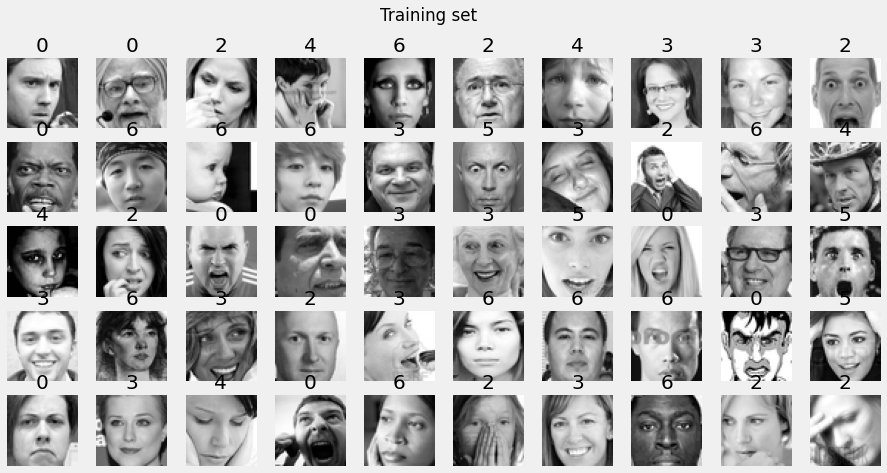

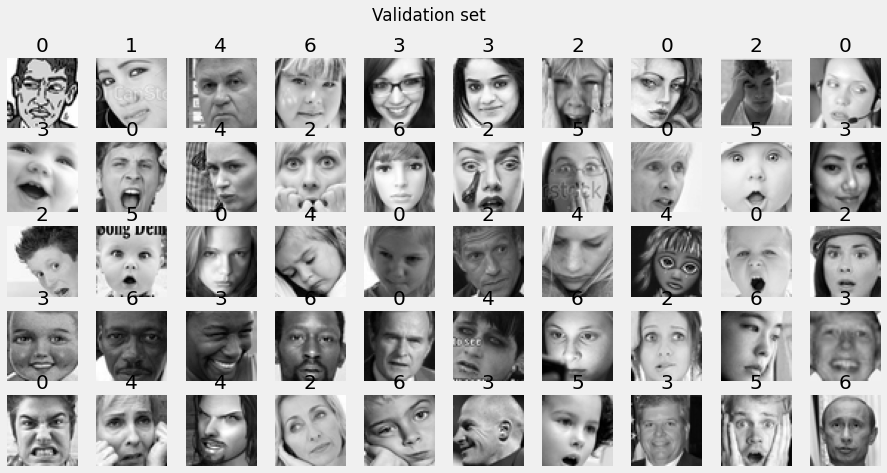

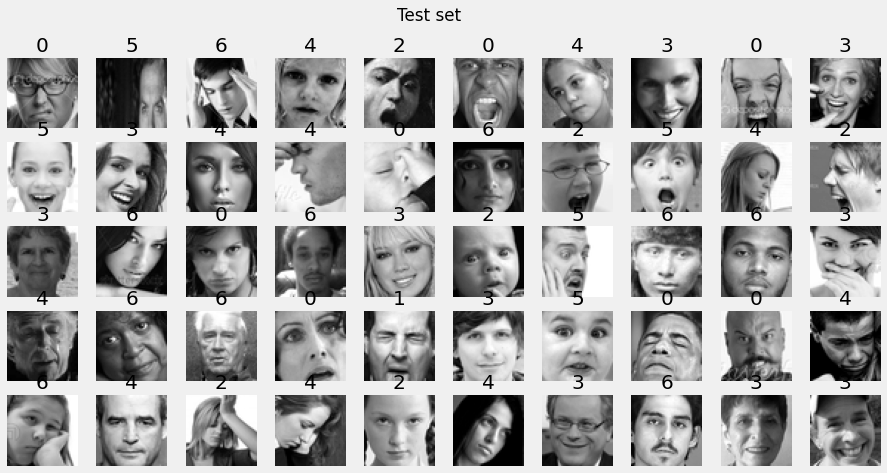

In [130]:
from matplotlib import pyplot as plt

plt.figure(figsize=(14, 7))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.imshow(x_train[i].reshape(height, width), cmap= 'gray')
  plt.axis('Off')
  plt.title(np.argmax(y_train[i])) 
# plt.tight_layout()
plt.suptitle('Training set')

plt.figure(figsize=(14, 7))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.imshow(x_val[i].reshape(height, width), cmap= 'gray')
  plt.axis('Off')
  plt.title(np.argmax(y_val[i])) 
# plt.tight_layout()
plt.suptitle('Validation set')

plt.figure(figsize=(14, 7))
for i in range(50):
  plt.subplot(5,10,i+1)
  plt.imshow(x_test[i].reshape(height, width), cmap= 'gray')
  plt.axis('Off')
  plt.title(np.argmax(y_test[i])) 
# plt.tight_layout()
plt.suptitle('Test set')

# Train the network

In [0]:
batch_size = 128
epochs = 15

In [0]:
from keras.preprocessing.image import ImageDataGenerator

def train(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_val, y_val) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    # compile the model
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],  
                  loss_weights=[1.0, 0.0005], 
                  metrics={'out_caps': 'accuracy'})

    # history = model.fit([x_train, y_train], [y_train, x_train], batch_size=batch_size, epochs=epochs,
    #           validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size):
        train_datagen = ImageDataGenerator(zca_whitening=True)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, batch_size),
                        steps_per_epoch=int(y_train.shape[0] / batch_size),
                        epochs=epochs,
                        validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [133]:
train(model=model, data=((x_train, y_train), (x_val, y_val)))

Epoch 1/15
224/224 [==============================] - 300s 1s/step - loss: 0.5169 - out_caps_loss: 0.5169 - out_recon_loss: 0.0650 - out_caps_acc: 0.2723 - val_loss: 0.4211 - val_out_caps_loss: 0.4211 - val_out_recon_loss: 0.0649 - val_out_caps_acc: 0.3525

Epoch 00001: val_loss improved from inf to 0.42109, saving model to weights-01.h5
Epoch 2/15
224/224 [==============================] - 300s 1s/step - loss: 0.4147 - out_caps_loss: 0.4147 - out_recon_loss: 0.0648 - out_caps_acc: 0.3524 - val_loss: 0.4044 - val_out_caps_loss: 0.4044 - val_out_recon_loss: 0.0646 - val_out_caps_acc: 0.3820

Epoch 00002: val_loss improved from 0.42109 to 0.40443, saving model to weights-02.h5
Epoch 3/15
224/224 [==============================] - 298s 1s/step - loss: 0.4003 - out_caps_loss: 0.4002 - out_recon_loss: 0.0646 - out_caps_acc: 0.3838 - val_loss: 0.3982 - val_out_caps_loss: 0.3982 - val_out_recon_loss: 0.0643 - val_out_caps_acc: 0.3856

Epoch 00003: val_loss improved from 0.40443 to 0.39823, sa

In [134]:
y_pred, x_recon = model.predict([x_test, y_test], batch_size=batch_size)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Test acc: 0.4797993870158819


# Visualisation

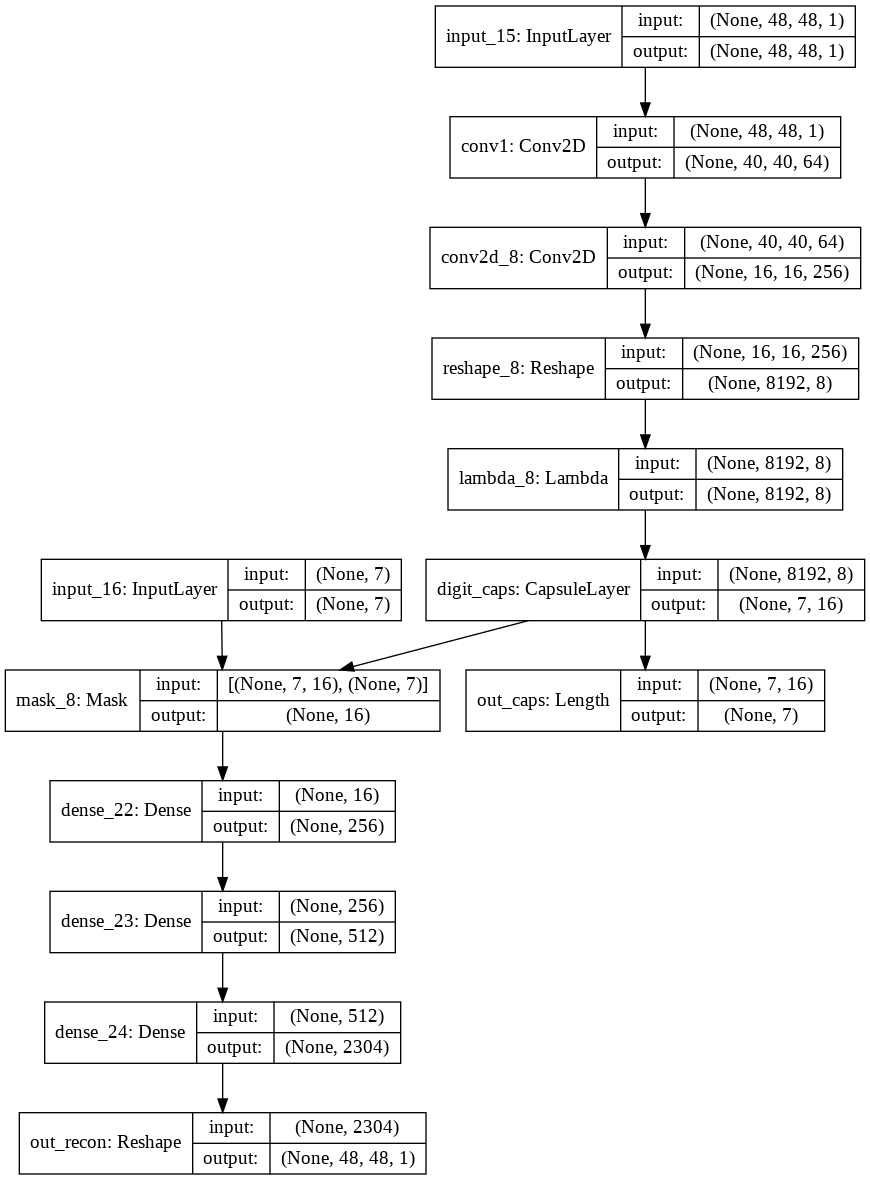

In [135]:
from IPython.display import Image
Image('model.png', width=750, height=750)

In [136]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv('log.csv')
print(df.columns)

Index(['epoch', 'loss', 'lr', 'out_caps_acc', 'out_caps_loss',
       'out_recon_loss', 'val_loss', 'val_out_caps_acc', 'val_out_caps_loss',
       'val_out_recon_loss'],
      dtype='object')


Filter the values to visualise

In [0]:
# loss
loss = df['loss'].to_list()
val_loss = df['val_loss'].to_list()

# Break-down the losses into components
out_caps_loss = df['out_caps_loss'].to_list()
val_out_caps_loss = df['val_out_caps_loss'].to_list()

out_recon_loss = df['out_recon_loss'].to_list()
val_out_recon_loss = df['val_out_recon_loss'].to_list()

# accuracy
out_caps_acc = df['out_caps_acc'].to_list()
val_out_caps_acc = df['val_out_caps_acc'].to_list()

Configure plotting tool(here: matplotlib)

In [0]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
plt.style.use('fivethirtyeight')
plt.rc('grid', color='k', linestyle='--')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='gray', axisbelow=True, grid=True)

Plot the loss and accuracy values

Text(0.5, 1.0, 'Training and Validation Reconstruction Loss')

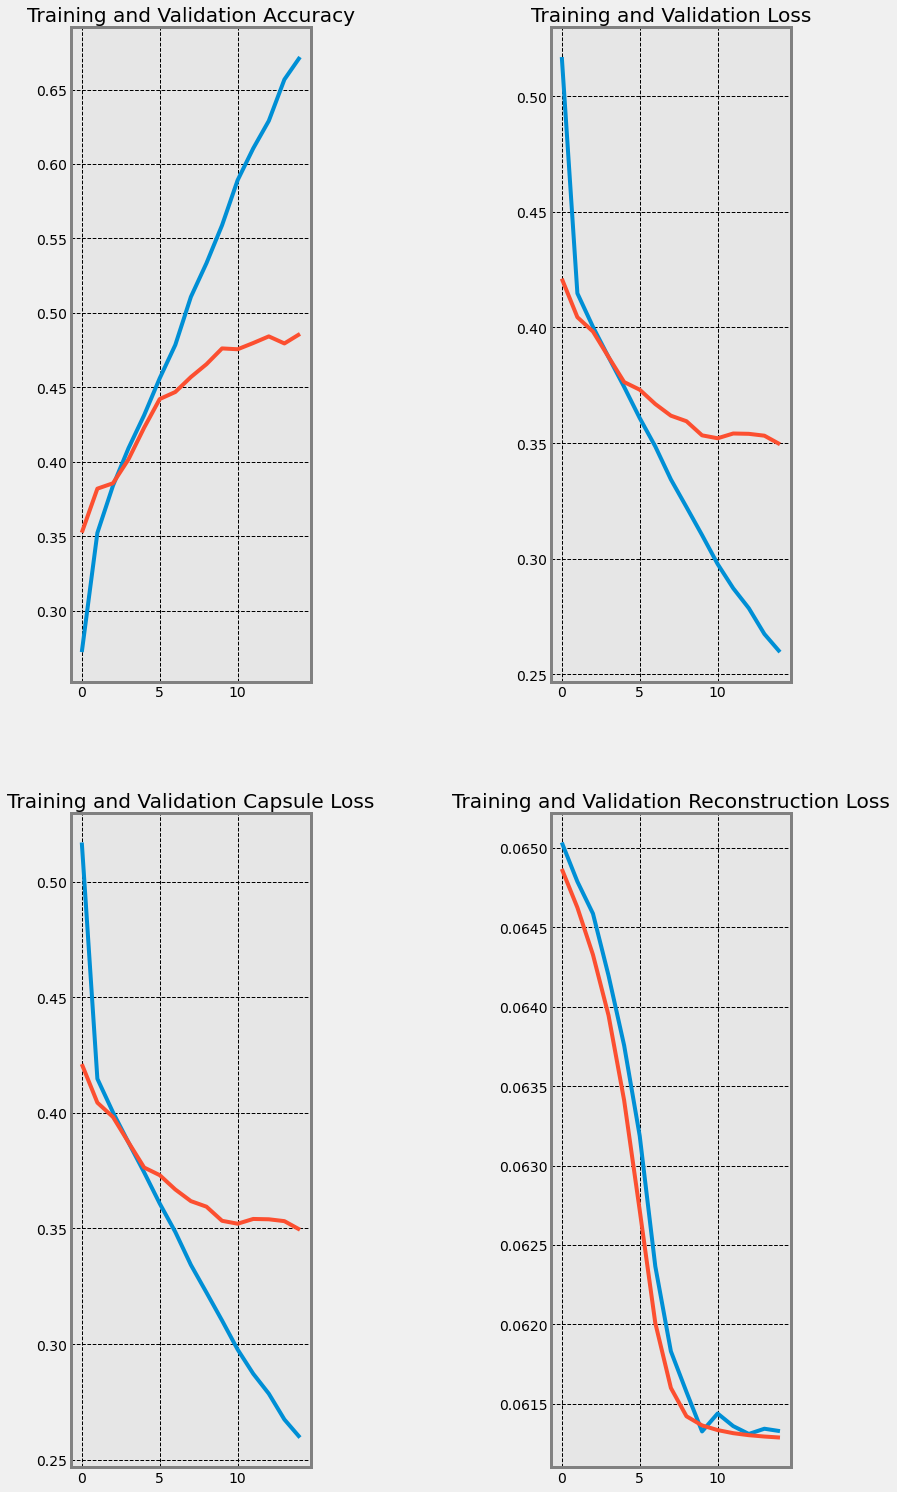

In [139]:
epochs = range(len(loss))

params = {'left' : 1,
          'right' : 3,
          'bottom' : 1,
          'top' : 3, 
          'wspace' : 1,                        
          'hspace' : 0.2}
              
plt.subplots_adjust(**params)

# Plot retrieved data : accuracy
plt.subplot(221)
plt.plot(epochs, out_caps_acc)
plt.plot(epochs, val_out_caps_acc)
plt.title("Training and Validation Accuracy")

# Plot retrieved data : loss
plt.subplot(222)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation Loss")

# Plot retrieved data : capsule loss
plt.subplot(223)
plt.plot(epochs, out_caps_loss)
plt.plot(epochs, val_out_caps_loss)
plt.title("Training and Validation Capsule Loss")

# Plot retrieved data : capsule loss
plt.subplot(224)
plt.plot(epochs, out_recon_loss)
plt.plot(epochs, val_out_recon_loss)
plt.title("Training and Validation Reconstruction Loss")

Reconstruction

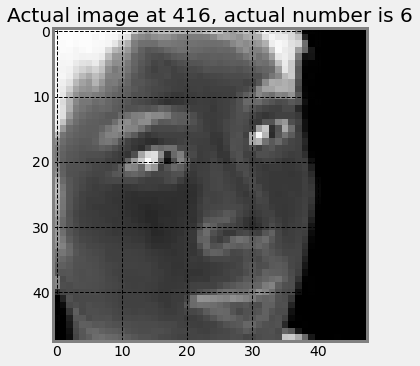

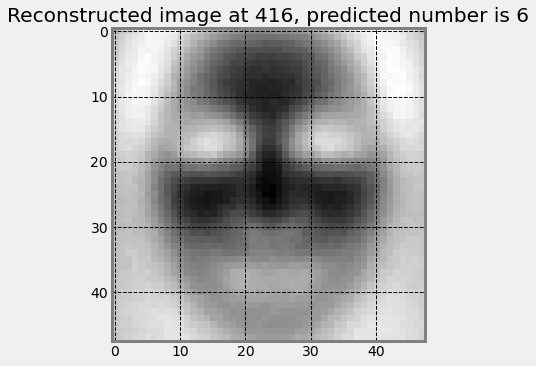

In [140]:
import random
index = random.randint(1, 3000)
plt.imshow(x_test[index].reshape(height, width), cmap=plt.cm.binary)
plt.title(f'Actual image at {index}, actual number is {np.argmax(y_test[index])}')
plt.show()
plt.imshow(x_recon[index].reshape(height, width), cmap=plt.cm.binary)
plt.title(f'Reconstructed image at {index}, predicted number is {np.argmax(y_pred[index])}')
plt.show()